In [1]:
# Import required modules# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np


# Get mpi info
comm = MPI.COMM_WORLD

# Data types
import sys
sys.path.append("C:\\Users\\bhask\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages")

from pynektools.datatypes.msh import Mesh
from pynektools.datatypes.coef import Coef
from pynektools.datatypes.field import Field, FieldRegistry

# Readers
from pynektools.io.ppymech.neksuite import preadnek, pynekread

# Writers
from pynektools.io.ppymech.neksuite import pwritenek, pynekwrite

# fname_2d = r"D:\HiWi\Jupyter\HiWi\field1.f00000"
fname_3d = r"D:\HiWi\Jupyter\HiWi\field2.f00000"

In [2]:
msh_3d = Mesh(comm, create_connectivity=False)
pynekread(fname_3d, comm, data_dtype=np.single, msh=msh_3d)
data_3d = preadnek(fname_3d, comm, data_dtype=np.single)
msh_3d = Mesh(comm, data=data_3d, create_connectivity=False)

2024-12-02 11:03:20,411 - Mesh - INFO - Initializing empty Mesh object.
2024-12-02 11:03:20,411 - pynekread - INFO - Reading file: D:\HiWi\Jupyter\HiWi\field2.f00000
2024-12-02 11:03:21,070 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2024-12-02 11:03:21,070 - Mesh - INFO - Initializing common attributes.
2024-12-02 11:03:21,070 - Mesh - INFO - Getting vertices
2024-12-02 11:03:21,113 - Mesh - INFO - Getting edge centers
2024-12-02 11:03:22,200 - Mesh - INFO - Getting facet centers
2024-12-02 11:03:22,900 - Mesh - INFO - Mesh object initialized.
2024-12-02 11:03:22,900 - Mesh - INFO - Mesh data is of type: float32
2024-12-02 11:03:22,900 - Mesh - INFO - Elapsed time: 1.8379666000000014s
2024-12-02 11:03:22,900 - pynekread - INFO - File read
2024-12-02 11:03:22,915 - pynekread - INFO - Elapsed time: 2.5042224000000033s
2024-12-02 11:03:22,939 - preadnek - INFO - Reading file: D:\HiWi\Jupyter\HiWi\field2.f00000
2024-12-02 11:03:28,897 - preadnek - INFO - Elapsed time: 5.

In [3]:
x = msh_3d.x.copy().astype(np.float64)
y = msh_3d.y.copy().astype(np.float64)
z = msh_3d.z.copy().astype(np.float64)

# 2.Initialize a new mesh object
msh_3d_sub = Mesh(comm, create_connectivity=False)
msh_3d_sub.init_from_coords(comm, x=x, y=y, z=z)

coef_3d = Coef(msh_3d, comm, get_area=True)

fld_3d = Field(comm)

pynekread(fname_3d, comm, data_dtype=np.single, fld=fld_3d)

data_3d = preadnek(fname_3d, comm, data_dtype=np.single)

fld_3d = Field(comm, data=data_3d)

for key in fld_3d.fields.keys():
    print(f'{key} has {len(fld_3d.fields[key])} fields')

u = fld_3d.fields['vel'][0]
v = fld_3d.fields['vel'][1]
w = fld_3d.fields['vel'][2]
p = fld_3d.fields['pres'][0]
# t = fld_3d.fields['temp'][0]


mag = np.sqrt(u**2 + v**2 + w**2)
fld_3d.fields['scal'].append(mag)
fld_3d.update_vars()

2024-12-02 11:03:37,167 - Mesh - INFO - Initializing empty Mesh object.
2024-12-02 11:03:37,167 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2024-12-02 11:03:37,167 - Mesh - INFO - Initializing common attributes.
2024-12-02 11:03:37,181 - Mesh - INFO - Getting vertices
2024-12-02 11:03:37,238 - Mesh - INFO - Getting edge centers
2024-12-02 11:03:38,790 - Mesh - INFO - Getting facet centers
2024-12-02 11:03:39,624 - Mesh - INFO - Mesh object initialized.
2024-12-02 11:03:39,624 - Mesh - INFO - Mesh data is of type: float64
2024-12-02 11:03:39,624 - Mesh - INFO - Elapsed time: 2.4587774999999965s
2024-12-02 11:03:39,624 - Coef - INFO - Initializing Coef object
2024-12-02 11:03:39,639 - Coef - INFO - Getting derivative matrices
2024-12-02 11:03:39,662 - Coef - INFO - Calculating the components of the jacobian
2024-12-02 11:03:58,745 - Coef - INFO - Calculating the jacobian determinant and inverse of the jacobian matrix
2024-12-02 11:04:03,086 - Coef - INFO - Calculating t

In [4]:
fname_out = 'D:/HiWi/Jupyter/HiWi/field_out3.f00000'

pynekwrite(fname_out, comm, msh=msh_3d, fld=fld_3d, write_mesh=True, wdsz=4)

fld_3d_r = FieldRegistry(comm)
pynekread(fname_3d, comm, data_dtype=np.single, fld=fld_3d_r)

for key in fld_3d_r.registry.keys():
    print(f'{key} has {fld_3d_r.registry[key].dtype} dtype')

fld_3d_r.add_field(comm, field_name='mag', field=mag, dtype=mag.dtype)
print(f'Field mag added to registry and fields directory in pos {fld_3d_r.registry_pos["mag"]}')

fld_3d_r.add_field(comm, field_name='mag_r', file_name=fname_out, file_type='fld', file_key='scal_0', dtype=mag.dtype)
print(f'Field mag_r added to registry and fields directory in pos {fld_3d_r.registry_pos["mag_r"]}')

eq = np.allclose(fld_3d_r.registry['mag'], fld_3d_r.registry['mag_r'])
print(eq)

fld_3d_r.add_field(comm, field_name='ones', field=np.ones_like(mag), dtype=mag.dtype)
print(fld_3d_r.registry_pos['ones'])
print(fld_3d_r.registry['ones'][100,0,:,:])
print(fld_3d_r.fields['scal'][2][100,0,:,:])

fld_3d_r.registry['ones'][100,0,:,:] = 2.0
print(fld_3d_r.fields['scal'][2][100,0,:,:])

fld_3d_r.fields['scal'][2][100,0,:,:] = 3.0
print(fld_3d_r.registry['ones'][100,0,:,:])

zeros = np.zeros_like(mag)

try:
    fld_3d_r.registry['ones'] = zeros
except KeyError as e:
    print(e)

fld_3d_r.add_field(comm, field_name='ones', field=zeros, dtype=zeros.dtype)
print(fld_3d_r.fields['scal'][2][100,0,:,:])

2024-12-02 11:04:31,073 - pynekwrite - INFO - Writing file: D:/HiWi/Jupyter/HiWi/field_out3.f00000
2024-12-02 11:04:37,585 - pynekwrite - INFO - Elapsed time: 6.521281200000004s
2024-12-02 11:04:37,648 - Field - INFO - Initializing empty Field object
2024-12-02 11:04:37,648 - pynekread - INFO - Reading file: D:\HiWi\Jupyter\HiWi\field2.f00000
2024-12-02 11:04:37,664 - pynekread - INFO - Reading field data
2024-12-02 11:04:39,062 - pynekread - INFO - File read
2024-12-02 11:04:39,062 - pynekread - INFO - Elapsed time: 1.4094147000000135s
u has float32 dtype
v has float32 dtype
w has float32 dtype
p has float32 dtype
Field mag added to registry and fields directory in pos scal_0
2024-12-02 11:04:39,127 - pynekread_field - INFO - Reading field: scal_0 from file: D:/HiWi/Jupyter/HiWi/field_out3.f00000
2024-12-02 11:04:39,386 - pynekread_field - INFO - File read
2024-12-02 11:04:39,386 - pynekread_field - INFO - Elapsed time: 0.27227510000000166s
Field mag_r added to registry and fields dir

In [5]:
from pynektools.io.wrappers import read_data

data = read_data(comm, fname_out, ["x", "y", "z", "scal_0"], dtype = np.single)

print(np.allclose(data["x"], msh_3d.x))
print(np.allclose(data["y"], msh_3d.y))
print(np.allclose(data["z"], msh_3d.z))
print(np.allclose(data["scal_0"], fld_3d_r.registry['mag_r']))

# Extract global coordinates of elements
x_global = data["x"]  # Shape: (num_elements, 8, 8, 8)
y_global = data["y"]
z_global = data["z"]

print(data["x"].shape)

2024-12-02 11:04:51,321 - Field - INFO - Initializing empty Field object
2024-12-02 11:04:51,321 - Mesh - INFO - Initializing empty Mesh object.
2024-12-02 11:04:51,321 - pynekread - INFO - Reading file: D:/HiWi/Jupyter/HiWi/field_out3.f00000
2024-12-02 11:04:56,128 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2024-12-02 11:04:56,128 - Mesh - INFO - Initializing common attributes.
2024-12-02 11:04:56,144 - Mesh - INFO - Getting vertices
2024-12-02 11:04:56,191 - Mesh - INFO - Getting edge centers
2024-12-02 11:04:57,586 - Mesh - INFO - Getting facet centers
2024-12-02 11:04:58,563 - Mesh - INFO - Creating connectivity
2024-12-02 11:06:24,727 - Mesh - INFO - Mesh object initialized.
2024-12-02 11:06:24,728 - Mesh - INFO - Mesh data is of type: float32
2024-12-02 11:06:24,728 - Mesh - INFO - Elapsed time: 88.5977308s
2024-12-02 11:06:24,730 - pynekread - INFO - File read
2024-12-02 11:06:24,731 - pynekread - INFO - Elapsed time: 93.40725149999997s
2024-12-02 11:06:25,027

In [10]:
size = 1000
subset_x = x_global[:size] 
subset_y = y_global[:size] 
subset_z = z_global[:size] 

print(f"subset_x shape: {subset_x.shape}")

subset = np.stack((subset_x, subset_y, subset_z), axis=-1) 
print(f"Subset shape: {subset.shape}")
print(f"x_global shape: {x_global.shape}")

subset_x shape: (1000, 8, 8, 8)
Subset shape: (1000, 8, 8, 8, 3)
x_global shape: (129024, 8, 8, 8)


In [11]:
# Methods for cal. the difference and normal vectors

def calculate_face_differences(subset):
    r_diff = np.mean(subset[:, :, :, 0, :] - subset[:, :, :, -1, :], axis=(1, 2))  # Front vs. Back, w/o reduction, shape (N,8,8,3)        
    s_diff = np.mean(subset[:, :, 0, :, :] - subset[:, :, -1, :, :], axis=(1, 2))  # Top vs. Bottom, w/o reduction, shape (N,8,8,3)
    t_diff = np.mean(subset[:, 0, :, :, :] - subset[:, -1, :, :, :], axis=(1, 2))  # Left vs. Right, w/o reduction, shape (N,8,8,3)
    return r_diff, s_diff, t_diff

def calculate_face_averages(subset):
    r_avg_diff = np.mean(subset[:, :, :, 0, :], axis=(1, 2)) - np.mean(subset[:, :, :, -1, :], axis=(1, 2)) # Front vs. Back
    s_avg_diff = np.mean(subset[:, :, 0, :, :], axis=(1, 2)) - np.mean(subset[:, :, -1, :, :], axis=(1, 2)) # Top vs. Bottom
    t_avg_diff = np.mean(subset[:, 0, :, :, :], axis=(1, 2)) - np.mean(subset[:, -1, :, :, :], axis=(1, 2)) # Left vs. Right
    return r_avg_diff, s_avg_diff, t_avg_diff

def calculate_face_normals(subset):
    normals = np.zeros((subset.shape[0], 6, 3))  # 6 faces per element

    mid = (subset.shape[1]) // 2
    offset = 1 if mid % 2 == 0 else 2

    # Normals for the r (front/back)
    front_edges1 = subset[:, mid, mid, 0, :] - subset[:, mid + offset, mid + offset, 0, :]
    front_edges2 = subset[:, mid, mid + offset, 0, :] - subset[:, mid + offset, mid, 0, :]

    back_edges1 = subset[:, mid, mid, -1, :] - subset[:, mid + offset, mid + offset, -1, :]
    back_edges2 = subset[:, mid, mid + offset, -1, :] - subset[:, mid + offset, mid, -1, :]

    normals[:, 0, :] = np.cross(front_edges1, front_edges2)
    normals[:, 1, :] = np.cross(back_edges1, back_edges2)

    # Normals for the t (left/right)
    left_edges1 = subset[:, 0, mid, mid, :] - subset[:, 0, mid + offset, mid + offset, :]
    left_edges2 = subset[:, 0, mid, mid + offset, :] - subset[:, 0, mid + offset, mid, :]

    right_edges1 = subset[:, -1, mid, mid, :] - subset[:, -1, mid + offset, mid + offset, :]
    right_edges2 = subset[:, -1, mid, mid + offset, :] - subset[:, -1, mid + offset, mid, :]

    normals[:, 2, :] = np.cross(left_edges1, left_edges2)
    normals[:, 3, :] = np.cross(right_edges1, right_edges2)

    # Normals for the s (top/bottom)
    top_edges1 = subset[:, mid, -1, mid, :] - subset[:, mid + offset, -1, mid + offset, :]
    top_edges2 = subset[:, mid, -1, mid + offset, :] - subset[:, mid + offset, -1, mid, :]

    bottom_edges1 = subset[:, mid, 0, mid, :] - subset[:, mid + offset, 0, mid + offset, :]
    bottom_edges2 = subset[:, mid, 0, mid + offset, :] - subset[:, mid + offset, 0, mid, :]

    normals[:, 4, :] = np.cross(top_edges1, top_edges2)
    normals[:, 5, :] = np.cross(bottom_edges1, bottom_edges2)

    return normals

r_diff, s_diff, t_diff = calculate_face_differences(subset)
r_avg_diff, s_avg_diff, t_avg_diff = calculate_face_averages(subset)
normals = calculate_face_normals(subset)

# Output:
print("Face differences:", r_diff.shape, s_diff.shape, t_diff.shape)
print("Average differences:", r_avg_diff.shape, s_avg_diff.shape, t_avg_diff.shape)
print("Normals shape:", normals.shape)

Face differences: (1000, 3) (1000, 3) (1000, 3)
Average differences: (1000, 3) (1000, 3) (1000, 3)
Normals shape: (1000, 6, 3)


In [12]:
# Face_differences

def directions_face_differences(r_diff, s_diff, t_diff):
    
    num_elements = subset.shape[0]
    mappings_fd = []

    for elem in range(num_elements):
        # Combine into a matrix for looping
        reduced_data = np.array([np.abs(r_diff[elem]), np.abs(s_diff[elem]), np.abs(t_diff[elem])])

        mapping = [""] * 3
        directions = ['x', 'y', 'z']
        assigned = [False] * 3 # Track assigned directions

        # Find the direction with the largest diff for each r, s, and t in the above-combined matrix
        for i in range(3):
            max_dir = np.argmax(reduced_data[i]) # here we get index of max value

            # avoid repetition of looking in the same index again and again
            while max_dir < len(directions) and assigned[max_dir]:
                reduced_data[i, max_dir] = -np.inf  # Invalidate this
                max_dir = np.argmax(reduced_data[i])

            if max_dir < len(directions):
                mapping[i] = directions[max_dir]
                assigned[max_dir] = True
            else:
                print(f"Error: max_dir ({max_dir}) out of range for directions list.")

        if not all(assigned):
            print(f"Unassigned directions in element {elem}, please check data.")
        else:
            mappings_fd.append(tuple(mapping))
    return mappings_fd           

mappings_fd = directions_face_differences(r_diff, s_diff, t_diff)

# Output:
for i, mapping in enumerate(mappings_fd[:1000]):
    print(f"Element {i}: r -> {mapping[0]}, s -> {mapping[1]}, t -> {mapping[2]}")



Element 0: r -> x, s -> y, t -> z
Element 1: r -> x, s -> y, t -> z
Element 2: r -> x, s -> y, t -> z
Element 3: r -> x, s -> y, t -> z
Element 4: r -> x, s -> y, t -> z
Element 5: r -> x, s -> y, t -> z
Element 6: r -> x, s -> y, t -> z
Element 7: r -> x, s -> y, t -> z
Element 8: r -> x, s -> y, t -> z
Element 9: r -> x, s -> y, t -> z
Element 10: r -> x, s -> y, t -> z
Element 11: r -> x, s -> y, t -> z
Element 12: r -> y, s -> x, t -> z
Element 13: r -> y, s -> x, t -> z
Element 14: r -> y, s -> x, t -> z
Element 15: r -> y, s -> x, t -> z
Element 16: r -> y, s -> x, t -> z
Element 17: r -> y, s -> x, t -> z
Element 18: r -> y, s -> x, t -> z
Element 19: r -> y, s -> x, t -> z
Element 20: r -> y, s -> x, t -> z
Element 21: r -> y, s -> x, t -> z
Element 22: r -> y, s -> x, t -> z
Element 23: r -> y, s -> x, t -> z
Element 24: r -> x, s -> y, t -> z
Element 25: r -> x, s -> y, t -> z
Element 26: r -> x, s -> y, t -> z
Element 27: r -> x, s -> y, t -> z
Element 28: r -> x, s -> y, t 

In [13]:
# Average_Face_differences

def directions_face_averages(r_avg_diff, s_avg_diff, t_avg_diff):
    
    num_elements = subset.shape[0]
    mappings_fa = []

    for elem in range(num_elements):
        # Combine into a matrix for looping
        reduced_data = np.array([np.abs(r_avg_diff[elem]), np.abs(s_avg_diff[elem]), np.abs(t_avg_diff[elem])])
        
        mapping = [""] * 3
        directions = ['x', 'y', 'z']
        assigned = [False] * 3 # Track assigned directions

        # Find the direction with the largest diff for each r, s, and t in the above-combined matrix
        for i in range(3):
            max_dir = np.argmax(reduced_data[i]) # here we get index of max value

            # avoid repetition of looking in the same index again and again
            while max_dir < len(directions) and assigned[max_dir]:
                reduced_data[i, max_dir] = -np.inf  # Invalidate this
                max_dir = np.argmax(reduced_data[i])

            if max_dir < len(directions):
                mapping[i] = directions[max_dir]
                assigned[max_dir] = True
            else:
                print(f"Error: max_dir ({max_dir}) out of range for directions list.")

        if not all(assigned):
            print(f"Unassigned directions in element {elem}, please check data.")
        else:
            mappings_fa.append(tuple(mapping))
    return mappings_fa

mappings_fa = directions_face_averages(r_avg_diff, s_avg_diff, t_avg_diff)

# Output:
for i, mapping in enumerate(mappings_fa[:1000]):
    print(f"Element {i}: r -> {mapping[0]}, s -> {mapping[1]}, t -> {mapping[2]}")

Element 0: r -> x, s -> y, t -> z
Element 1: r -> x, s -> y, t -> z
Element 2: r -> x, s -> y, t -> z
Element 3: r -> x, s -> y, t -> z
Element 4: r -> x, s -> y, t -> z
Element 5: r -> x, s -> y, t -> z
Element 6: r -> x, s -> y, t -> z
Element 7: r -> x, s -> y, t -> z
Element 8: r -> x, s -> y, t -> z
Element 9: r -> x, s -> y, t -> z
Element 10: r -> x, s -> y, t -> z
Element 11: r -> x, s -> y, t -> z
Element 12: r -> y, s -> x, t -> z
Element 13: r -> y, s -> x, t -> z
Element 14: r -> y, s -> x, t -> z
Element 15: r -> y, s -> x, t -> z
Element 16: r -> y, s -> x, t -> z
Element 17: r -> y, s -> x, t -> z
Element 18: r -> y, s -> x, t -> z
Element 19: r -> y, s -> x, t -> z
Element 20: r -> y, s -> x, t -> z
Element 21: r -> y, s -> x, t -> z
Element 22: r -> y, s -> x, t -> z
Element 23: r -> y, s -> x, t -> z
Element 24: r -> x, s -> y, t -> z
Element 25: r -> x, s -> y, t -> z
Element 26: r -> x, s -> y, t -> z
Element 27: r -> x, s -> y, t -> z
Element 28: r -> x, s -> y, t 

In [15]:

def align_normals(normals_pair):
    # Compute the dot product between pairs of normal vectors
    dot_products = np.einsum('ij,ij->i', normals_pair[:, 0, :], normals_pair[:, 1, :])
    
    # Flip normals that are opposite
    flip_mask = dot_products < 0
    normals_pair[flip_mask, 1, :] *= -1
    
    return normals_pair

def reduce_normals_by_faces(normals):
    # Separate normals by face pairs
    front_back_normals = normals[:, [0, 1], :] #r
    left_right_normals = normals[:, [2, 3], :] #t
    top_bottom_normals = normals[:, [4, 5], :] #s

    # Ensure normals are consistently oriented using np.dot
    front_back_normals = align_normals(front_back_normals)
    left_right_normals = align_normals(left_right_normals)
    top_bottom_normals = align_normals(top_bottom_normals)

    # Normalize the normals
    front_back_normals = front_back_normals / np.linalg.norm(front_back_normals, axis=2, keepdims=True)
    left_right_normals = left_right_normals / np.linalg.norm(left_right_normals, axis=2, keepdims=True)
    top_bottom_normals = top_bottom_normals / np.linalg.norm(top_bottom_normals, axis=2, keepdims=True)

    # Compute the averages
    averaged_front_back = np.mean(front_back_normals, axis=1)
    averaged_left_right = np.mean(left_right_normals, axis=1)
    averaged_top_bottom = np.mean(top_bottom_normals, axis=1)

    # Stack the averaged normals
    averaged_normals = np.stack([averaged_front_back, averaged_top_bottom, averaged_left_right,], axis=1)
    
    return averaged_normals
    
averaged_normals =  reduce_normals_by_faces(normals)

print("Averaged_normals shape:", averaged_normals.shape)

# print(averaged_normals[:2,:,:])

Averaged_normals shape: (1000, 3, 3)


In [16]:
def directions_face_normals(averaged_normals):
    num_elements = subset.shape[0]
    mappings = []

    for elem in range(num_elements):
        face_normals = np.abs(averaged_normals[elem])  # Shape: (3, 3)
        mapping = [""] * 3
        directions = ['x', 'y', 'z']
        
        assigned = [False] * 3

        for i in range(3):  # Iterate over the three pairs of normals
            max_dir = np.argmax(face_normals[i])  # here we get index of max value
            
            # Ensure unique assignment
            while max_dir < len(directions) and assigned[max_dir]:
                face_normals[i][max_dir] = -np.inf  # Invalidate this direction
                max_dir = np.argmax(face_normals[i])

            if max_dir < len(directions):
                mapping[i] = directions[max_dir]
                assigned[max_dir] = True

        if not all(assigned):
            print(f"Unassigned directions in element {elem}, please check data.")
        else:
            mappings.append(tuple(mapping))
    
    return mappings

mappings = directions_face_normals(averaged_normals)

# Output:
for i, mapping in enumerate(mappings[:1000]):
    print(f"Element {i}: r -> {mapping[0]}, s -> {mapping[1]}, t -> {mapping[2]}")


Element 0: r -> x, s -> y, t -> z
Element 1: r -> x, s -> y, t -> z
Element 2: r -> x, s -> y, t -> z
Element 3: r -> x, s -> y, t -> z
Element 4: r -> x, s -> y, t -> z
Element 5: r -> x, s -> y, t -> z
Element 6: r -> x, s -> y, t -> z
Element 7: r -> x, s -> y, t -> z
Element 8: r -> x, s -> y, t -> z
Element 9: r -> x, s -> y, t -> z
Element 10: r -> y, s -> x, t -> z
Element 11: r -> x, s -> y, t -> z
Element 12: r -> y, s -> x, t -> z
Element 13: r -> x, s -> y, t -> z
Element 14: r -> y, s -> x, t -> z
Element 15: r -> y, s -> x, t -> z
Element 16: r -> y, s -> x, t -> z
Element 17: r -> y, s -> x, t -> z
Element 18: r -> y, s -> x, t -> z
Element 19: r -> y, s -> x, t -> z
Element 20: r -> y, s -> x, t -> z
Element 21: r -> y, s -> x, t -> z
Element 22: r -> y, s -> x, t -> z
Element 23: r -> y, s -> x, t -> z
Element 24: r -> x, s -> y, t -> z
Element 25: r -> x, s -> y, t -> z
Element 26: r -> x, s -> y, t -> z
Element 27: r -> x, s -> y, t -> z
Element 28: r -> x, s -> y, t 

In [18]:
# Compare all three methods (verify only "t-direction"):

mappings_fa = directions_face_averages(r_avg_diff, s_avg_diff, t_avg_diff)
mappings_fd = directions_face_differences(r_diff, s_diff, t_diff)
mappings_fn = directions_face_normals(averaged_normals)

def compare_methods(mappings_fd, mappings_fa, mappings_fn):
    num_elements = r_diff.shape[0]
    match_count =0
    # print(num_elements)
    
    for i in range(num_elements): 
        # print(f"Element {i}:") 
        if mappings_fd[i][2] == mappings_fa[i][2] == mappings_fn[i][2]:     
            # print(" All mappings match.") 
            match_count += 1
        else: 
            print(" Mismatch found.")
            print(f" Face Diff Mapping: r -> {mappings_fd[i][0]}, s -> {mappings_fd[i][1]}, t -> {mappings_fd[i][2]}") 
            print(f" Face Avg Mapping: r -> {mappings_fa[i][0]}, s -> {mappings_fa[i][1]}, t -> {mappings_fa[i][2]}") 
            print(f" Normal Mapping: r -> {mappings_fn[i][0]}, s -> {mappings_fn[i][1]}, t -> {mappings_fn[i][2]}") 
    
    matching_percentage = (match_count / num_elements) * 100 
    print(f"Matching Percentage: {matching_percentage:.2f}%")

compare_methods(mappings_fd, mappings_fa, mappings_fn)

Matching Percentage: 100.00%


In [22]:
# Compare all three methods and verifying each r,s,t:

mappings_fa = directions_face_averages(r_avg_diff, s_avg_diff, t_avg_diff)
mappings_fd = directions_face_differences(r_diff, s_diff, t_diff)
mappings_fn = directions_face_normals(averaged_normals)

def compare_methods(mappings_fd, mappings_fa, mappings_fn):
    num_elements = r_diff.shape[0]
    match_count =0
    # print(num_elements)
    
    for i in range(num_elements): 
        print(f"Element {i}:") 
        if mappings_fd[i] == mappings_fa[i]== mappings_fn[i]: 
            # print(mappings_fd[i]) 
            # print(mappings_fa[i])    
            print(" All mappings match.") 
            match_count += 1
        else: 
            print(" Mismatch found.")
            print(f" Face Diff Mapping: r -> {mappings_fd[i][0]}, s -> {mappings_fd[i][1]}, t -> {mappings_fd[i][2]}") 
            print(f" Face Avg Mapping: r -> {mappings_fa[i][0]}, s -> {mappings_fa[i][1]}, t -> {mappings_fa[i][2]}") 
            print(f" Normal Mapping: r -> {mappings_fn[i][0]}, s -> {mappings_fn[i][1]}, t -> {mappings_fn[i][2]}") 
    
    matching_percentage = (match_count / num_elements) * 100 
    print(f"Matching Percentage: {matching_percentage:.2f}%")

compare_methods(mappings_fd, mappings_fa, mappings_fn)

Element 0:
 All mappings match.
Element 1:
 All mappings match.
Element 2:
 All mappings match.
Element 3:
 All mappings match.
Element 4:
 All mappings match.
Element 5:
 All mappings match.
Element 6:
 All mappings match.
Element 7:
 All mappings match.
Element 8:
 All mappings match.
Element 9:
 All mappings match.
Element 10:
 Mismatch found.
 Face Diff Mapping: r -> x, s -> y, t -> z
 Face Avg Mapping: r -> x, s -> y, t -> z
 Normal Mapping: r -> y, s -> x, t -> z
Element 11:
 All mappings match.
Element 12:
 All mappings match.
Element 13:
 Mismatch found.
 Face Diff Mapping: r -> y, s -> x, t -> z
 Face Avg Mapping: r -> y, s -> x, t -> z
 Normal Mapping: r -> x, s -> y, t -> z
Element 14:
 All mappings match.
Element 15:
 All mappings match.
Element 16:
 All mappings match.
Element 17:
 All mappings match.
Element 18:
 All mappings match.
Element 19:
 All mappings match.
Element 20:
 All mappings match.
Element 21:
 All mappings match.
Element 22:
 All mappings match.
Element 2

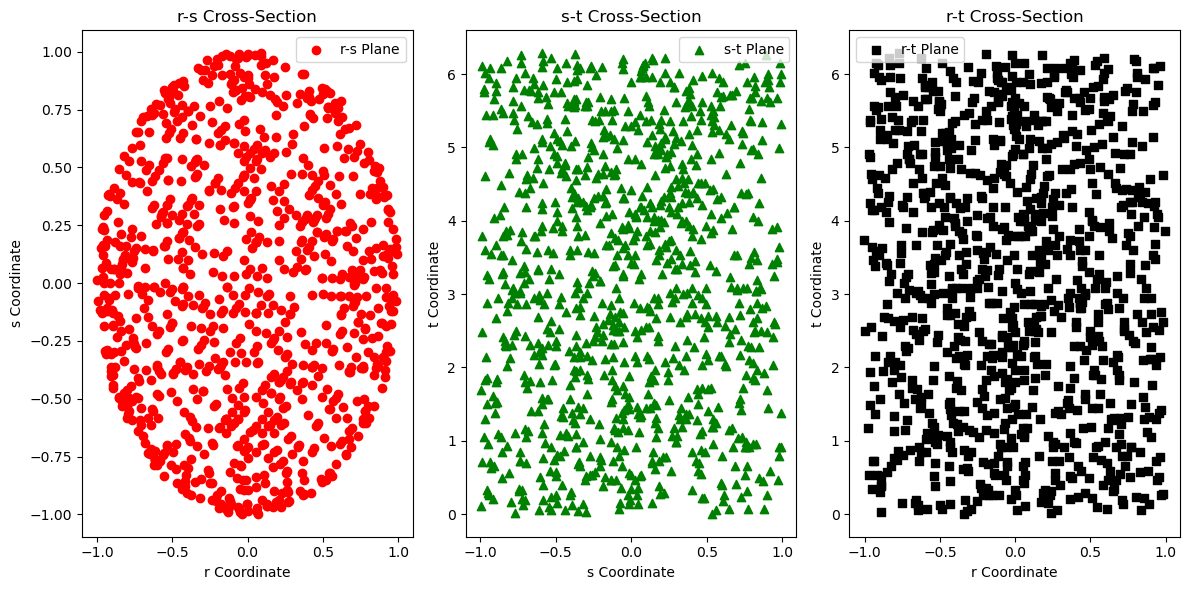

<Figure size 640x480 with 0 Axes>

In [23]:
r_global = data["x"]
s_global = data["y"]
t_global = data["z"]

num_samples = 1000

# cross-section (at the middle t-plane)
mid_t = t_global.shape[2] // 2
r_cross_section = r_global[:, :, :, mid_t]
s_cross_section = s_global[:, :, :, mid_t]
t_cross_section = t_global[:, :, :, mid_t]

# Flatten the arrays to 1D for plotting
r_flat = r_cross_section.flatten()
s_flat = s_cross_section.flatten()
t_flat = t_cross_section.flatten()

# Create an array of indices and randomly sample from it
indices = np.arange(r_flat.shape[0])
sample_indices = np.random.choice(indices, size=num_samples, replace=False)

# Extract the sampled points
r_sampled = r_flat[sample_indices]
s_sampled = s_flat[sample_indices]
t_sampled = t_flat[sample_indices]
plt.figure(figsize=(12, 6))

# Create a 2D plot for the cross-section with different colors and markers
# Plot X vs Y 
plt.subplot(1, 3, 1) 
plt.scatter(r_sampled, s_sampled, c='r', marker='o', label='r-s Plane') 
plt.xlabel('r Coordinate') 
plt.ylabel('s Coordinate') 
plt.title('r-s Cross-Section') 
plt.legend()

# Plot Y vs Z 
plt.subplot(1, 3, 2) 
plt.scatter(s_sampled, t_sampled, c='g', marker='^', label='s-t Plane') 
plt.xlabel('s Coordinate') 
plt.ylabel('t Coordinate') 
plt.title('s-t Cross-Section') 
plt.legend()

# Plot X vs Z 
plt.subplot(1, 3, 3) 
plt.scatter(r_sampled, t_sampled, c='k', marker='s', label='r-t Plane') 
plt.xlabel('r Coordinate') 
plt.ylabel('t Coordinate') 
plt.title('r-t Cross-Section') 
plt.legend()

# Adjust layout and show the plot 
plt.tight_layout() 
plt.show() 

# Save the plot to a file 
plt.savefig('Cross_Section_Sampled.png', dpi=300, bbox_inches='tight')


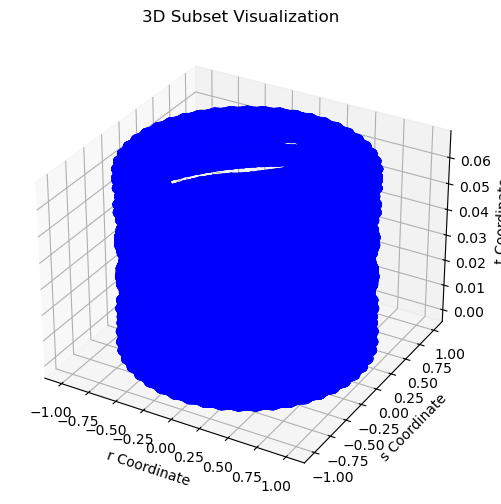

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Flatten the arrays to 2D for plotting
subset_flat = subset.reshape(-1, 3)

# Create a 3D scatter plot for the subset
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the subset points with a single color
ax.scatter(subset_flat[:, 0], subset_flat[:, 1], subset_flat[:, 2], c='b', marker='o')

# Labels
ax.set_xlabel('r Coordinate')
ax.set_ylabel('s Coordinate')
ax.set_zlabel('t Coordinate')
ax.set_title('3D Subset Visualization')

# Show the plot
plt.show()

# Save the plot to a file
plt.savefig('3D_Subset_Visualization.png', dpi=300, bbox_inches='tight')


In [ ]:
from mpl_tookkits.plot import Axes3D

subset_flat = subset.reshape(-1,3)

fig = 